In [20]:
import random

import matplotlib.pyplot as plt
import netrd
import networkx as nx
import numpy as np

random.seed(111)
np.random.seed(111)

# Dynamic Simulations Using the `netrd` package

In [21]:
# Build a stochastic block model network with three clusters.
cluster_sizes = [20, 10, 10]
cluster_connection_probs = [
    [.5, .05, .1],
    [.05, .5, .2],
    [.1, .2, .5],
]
num_nodes = sum(cluster_sizes)

G = nx.stochastic_block_model(cluster_sizes, cluster_connection_probs)

## Kuramoto Model

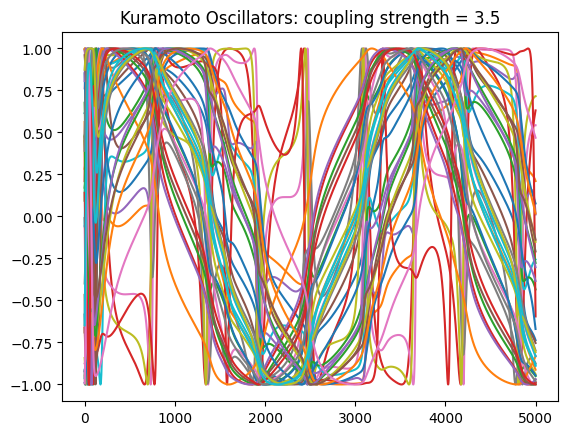

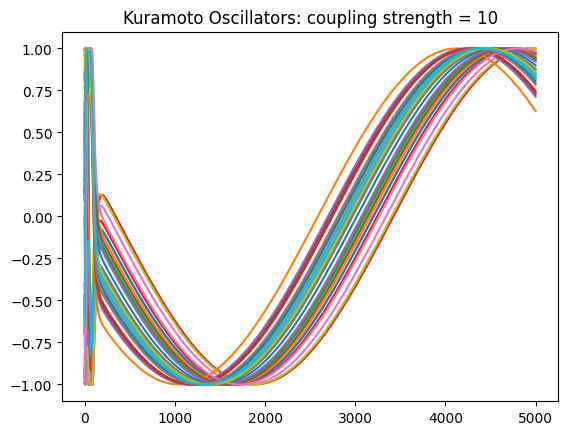

In [22]:

timeseries_length = 5000
timestep = 0.1
coupling_str = 3.5
# Initial phases distributed uniformly in [0, 2pi]
initial_phases = 2*np.pi*np.random.rand(num_nodes)
initial_freqs = np.random.rand(num_nodes) - .5

kuramoto_model = netrd.dynamics.Kuramoto()
X = kuramoto_model.simulate(
    G, 
    timeseries_length,
    strength=coupling_str,
    dt=timestep,
    phases=initial_phases,
    freqs=initial_freqs 
)

plt.title(f"Kuramoto Oscillators: coupling strength = {coupling_str}")
plt.plot(np.sin(X.T))
plt.show()

coupling_str = 10
X = kuramoto_model.simulate(
    G, 
    timeseries_length,
    strength=coupling_str,
    dt=timestep,
    phases=initial_phases,
    freqs=initial_freqs 
)

plt.title(f"Kuramoto Oscillators: coupling strength = {coupling_str}")
plt.plot(np.sin(X.T))
plt.show()

This is an interesting model. We could add noise and try to predict which oscilators are coupled to which. Would VAR be able to solve this? Probably not.

We could let coupling vary with time and be an exogenous input (although we would probably have to code our own version to do that).

## Lotka-Volterra Model

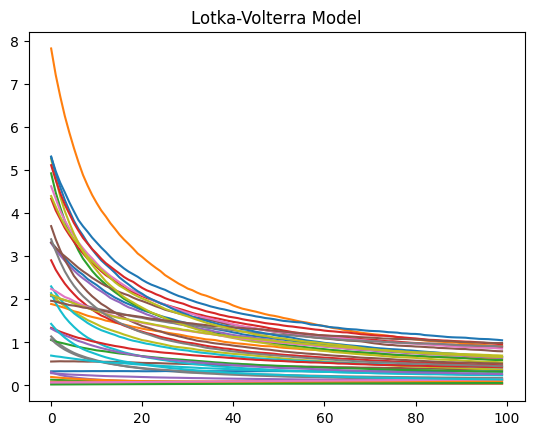

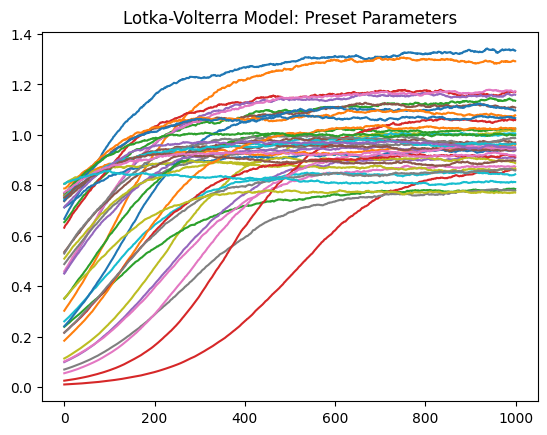

In [23]:
timeseries_length = 100

lv_model = netrd.dynamics.LotkaVolterra()
growth_rate = 0.1 * np.random.rand(num_nodes)
capacity = np.random.rand(num_nodes) * 10
initial_abundance = np.diag(capacity) @ np.random.rand(num_nodes) 

X = lv_model.simulate(
    G,
    timeseries_length,
    init=initial_abundance,
    gr=growth_rate,
    cap=capacity,
    inter=None,
    dt=timestep,
    stochastic=True,
    pertb=None,
)

plt.plot(X.T)
plt.title("Lotka-Volterra Model")
plt.show()

X = lv_model.simulate(
    G,
    1000,
)

plt.plot(X.T)
plt.title("Lotka-Volterra Model: Preset Parameters")

plt.show()

#### Found a bug in the source code!

In [24]:
# g = nx.fast_gnp_random_graph(10, .001)
# lv_model = netrd.dynamics.LotkaVolterra()
# lv_model.simulate(g, 100, stochastic=False)

## Ising Glauber Model 

In [25]:
# Parameters
timeseries_length = 200
init_state = (np.random.rand(num_nodes) < 0.5).astype(float)
temprature = 3.7

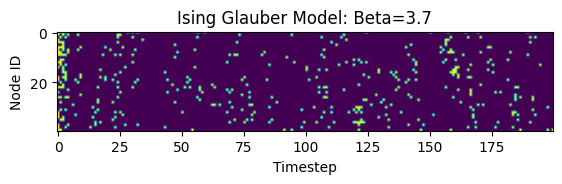

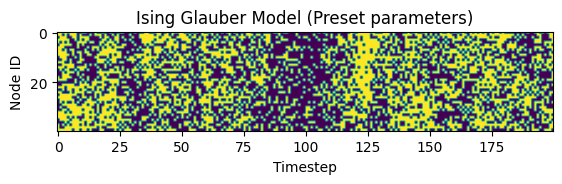

In [26]:
ig_model = netrd.dynamics.IsingGlauber()
X = ig_model.simulate(G, timeseries_length, init=init_state, beta=temprature)

plt.imshow(X)
plt.title(f"Ising Glauber Model: Beta={temprature}")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

ig_model = netrd.dynamics.IsingGlauber()
X = ig_model.simulate(G, timeseries_length, init=init_state)

plt.imshow(X)
plt.title("Ising Glauber Model (Preset parameters)")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

## SIS Model

In [27]:
# Parameters
timeseries_length = 200
initial_infected = 5
infection_rate = 0.15
recovery_rate = 0.5


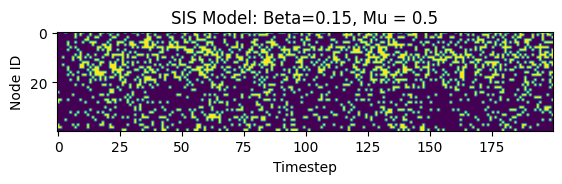

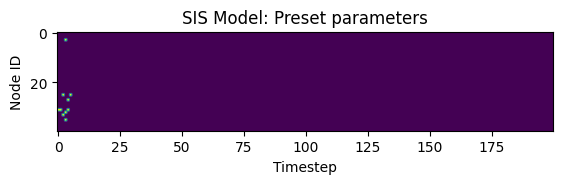

In [28]:
sis_model = netrd.dynamics.SISModel()
X = sis_model.simulate(
    G,
    timeseries_length,
    num_seeds=initial_infected,
    beta=infection_rate,
    mu=recovery_rate
)

plt.imshow(X)
plt.title(f"SIS Model: Beta={infection_rate}, Mu = {recovery_rate}")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

X = sis_model.simulate(G, timeseries_length)

plt.imshow(X)
plt.title(f"SIS Model: Preset parameters")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

## Voter Model

In [29]:
# Parameters
noise_level = 0.05

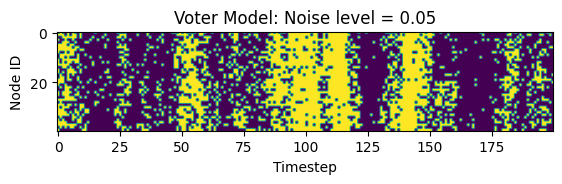

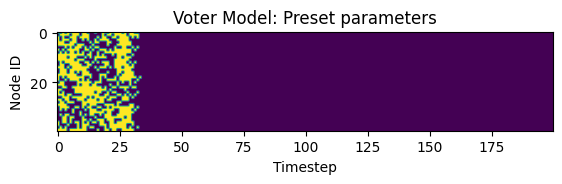

In [30]:
voter_model = netrd.dynamics.VoterModel()

X = voter_model.simulate(
    G,
    timeseries_length,
    noise=noise_level
)

plt.imshow(X)
plt.title(f"Voter Model: Noise level = {noise_level}")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

X = voter_model.simulate(G, timeseries_length)

plt.imshow(X)
plt.title(f"Voter Model: Preset parameters")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

## Branching Process

In [31]:
# Parameters

timeseries_length = 200
initial_fraction_active = 0.5
branching_ratio = 0.9
desired_average_activity = 0.0

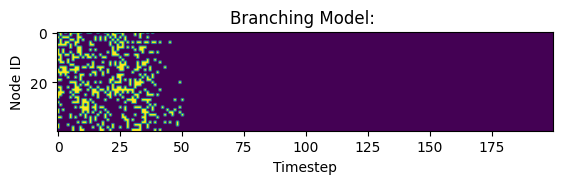

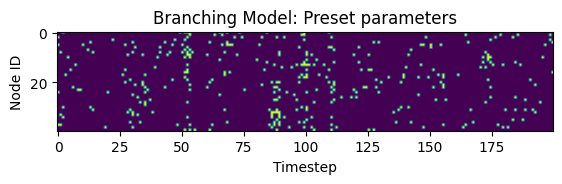

In [32]:
branching_model = netrd.dynamics.BranchingModel()

X = branching_model.simulate(
    G,
    timeseries_length,
    initial_fraction=initial_fraction_active,
    m =branching_ratio,
    target_Ahat=desired_average_activity,
)

plt.imshow(X)
plt.title(f"Branching Model: ")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

X = branching_model.simulate(G, timeseries_length)

plt.imshow(X)
plt.title(f"Branching Model: Preset parameters")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()